In [78]:
import numpy as np
import networkx as nx
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN, SimpleRNNCell, MultiHeadAttention, Input, GlobalAveragePooling1D, LayerNormalization, Dropout
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD, Nadam, Adagrad
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import random
from tensorflow.keras.utils import to_categorical
from collections import defaultdict
from tensorflow.keras.models import Model
from keras.layers import LeakyReLU
from tensorflow.keras import layers, models, optimizers, activations
from node2vec import Node2Vec
from collections import defaultdict
from keras.optimizers import AdamW
from tensorflow.keras.models import Model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import json
from sklearn.model_selection import StratifiedShuffleSplit

In [49]:
class TemporalRandomWalkSampler:
    def __init__(self, filename=None, num_walks=3, alpha=0.5):
        self.num_walks = num_walks
        self.alpha = alpha
        if filename:
            self.temporal_network = self.load_temporal_network(filename)
        else:
            self.temporal_network = nx.Graph()

    def load_temporal_network(self, filename):
        temporal_network = nx.Graph()
        with open(filename, 'r') as file:
            next(file)  # Skip header if there is one
            for line in file:
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    source, target, timestamp = parts
                    temporal_network.add_edge(source, target, time=int(timestamp))
                else:
                    print(f"Skipping invalid line: {line.strip()}")
        return temporal_network

    def sample_temporal_random_walks(self):
        node_sets = {}
        for node in self.temporal_network.nodes():
            walks = self._sample_trws(node)
            node_sets[node] = walks
        return node_sets

    def _sample_trws(self, start_node):
        walks = []
        for _ in range(self.num_walks):
            walk = self.temporal_walk(self.temporal_network, start_node)
            walks.append(walk)
        return walks

    def temporal_walk(self, G, start_node, L=7):
        current_node = start_node
        walk = [current_node]
        current_time = 0

        for _ in range(1, L + 1):
            neighbors = [(neighbor, G.edges[current_node, neighbor]['time']) for neighbor in G.neighbors(current_node)]
            valid_edges = [(neighbor, time) for neighbor, time in neighbors if time > current_time]

            if valid_edges:
                next_node, interaction_time = self.biased_edge_selection(valid_edges, current_time)
                walk.append(interaction_time)
                walk.append(next_node)
                current_node = next_node
                current_time = interaction_time
            else:
                break

        return walk

    def biased_edge_selection(self, valid_edges, current_time):
        weights = [np.exp(-self.alpha * (edge[1] - current_time)) for edge in valid_edges]
        sum_weights = np.sum(weights)

        if sum_weights == 0 or np.isnan(sum_weights):
            # Handle the case when all weights are zero or NaN
            return random.choice(valid_edges)
        else:
            normalized_weights = weights / sum_weights
            selected_index = np.random.choice(len(valid_edges), p=normalized_weights)
            return valid_edges[selected_index]

In [50]:
def extract_temporal_motifs(walks, motif_sizes):
    motifs = {}
    for size in motif_sizes:
        size_motifs = set()
        for walk in walks:
            for i in range(0, len(walk) - size * 2 + 1, 2):
                motif = tuple(walk[i:i + size * 2:2])
                size_motifs.add(motif)
        motifs[size] = size_motifs
    return motifs

def anonymize_motifs(motifs):
    node_encoder = OneHotEncoder()
    flattened_motifs = [str(node) for size in motifs for motif in motifs[size] for node in motif]
    node_encoder.fit(np.array(flattened_motifs).reshape(-1, 1))

    anonymized_motifs = {}
    for size, size_motifs in motifs.items():
        anonymized_size_motifs = set()
        for motif in size_motifs:
            encoded_motif = tuple(tuple(node_encoder.transform(np.array([[str(node)]]).reshape(-1, 1)).toarray().flatten()) for node in motif)
            anonymized_size_motifs.add(encoded_motif)
        anonymized_motifs[size] = anonymized_size_motifs

    return anonymized_motifs

def create_incidence_matrices(motifs):
    incidence_matrices = {}

    for size, size_motifs in motifs.items():
        vertices = set()
        hyperedges = []

        for motif in size_motifs:
            vertices.update(motif)
            hyperedges.append(motif)

        vertices = sorted(vertices)
        num_vertices = len(vertices)
        num_hyperedges = len(hyperedges)

        incidence_matrix = np.zeros((num_vertices, num_hyperedges))

        for j, hyperedge in enumerate(hyperedges):
            for vertex in hyperedge:
                i = vertices.index(vertex)
                incidence_matrix[i, j] = 1

        incidence_matrices[size] = (incidence_matrix, vertices, hyperedges)

    return incidence_matrices

def extract_node_features(temporal_network, incidence_matrices):
    node_features = defaultdict(list)

    for size, (incidence_matrix, vertices, hyperedges) in incidence_matrices.items():
        # Extract features from the incidence matrix for each node
        node_degree = incidence_matrix.sum(axis=1)  # Degree centrality
        node_closeness = np.reciprocal(incidence_matrix.sum(axis=1), where=(incidence_matrix.sum(axis=1) != 0))  # Closeness centrality
        node_betweenness = np.sum(incidence_matrix, axis=1)  # Betweenness centrality

        # Combine the features into a feature matrix
        features = np.column_stack((node_degree, node_closeness, node_betweenness))

        # Store the features in a dictionary with node labels as keys
        for node, feature in zip(vertices, features):
            node_features[node].append(feature)

    # Extract Node2Vec embeddings
    node2vec = Node2Vec(temporal_network, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    node2vec_features = {str(node): model.wv[str(node)] for node in temporal_network.nodes()}

    # Merge all features
    merged_features = {}
    max_motif_features_length = max(len(features) for features in node_features.values())

    for node in temporal_network.nodes():
        embedding_features = node2vec_features[str(node)]
        if node in node_features:
            basic_features = np.concatenate(node_features[node], axis=0)
            # Ensure uniform length by padding/trimming
            basic_features = pad_or_trim(basic_features, max_motif_features_length * 3)
            merged_features[node] = np.concatenate((basic_features, embedding_features))
        else:
            merged_features[node] = embedding_features

    return merged_features

In [51]:
# Merge features from all motif sizes and ensure uniform length by padding/trimming
def pad_or_trim(array, length):
    if len(array) < length:
        return np.pad(array, (0, length - len(array)), 'constant')
    else:
        return array[:length]

<H1>Data : CollegeMsg</H1>

In [52]:
# Example usage (same as provided above)
filename = '../Data/CollegeMsg.txt'  # Replace with your actual file path
temporal_rw_sampler = TemporalRandomWalkSampler(filename, num_walks=30, alpha=0.5)

In [53]:
node_sets = temporal_rw_sampler.sample_temporal_random_walks()
all_walks = [walk for walks in node_sets.values() for walk in walks]
motif_sizes = [3, 4, 5, 6]
extracted_motifs = extract_temporal_motifs(all_walks, motif_sizes)

incidence_matrices = create_incidence_matrices(extracted_motifs)
# Extract node features from the incidence matrices
node_features_dict = extract_node_features(temporal_rw_sampler.temporal_network, incidence_matrices)

Computing transition probabilities: 100%|█████████████████████████████████████████| 1899/1899 [00:09<00:00, 194.20it/s]


In [7]:
node_features_dict

{'3': array([ 1.95300000e+03,  5.12032770e-04,  1.95300000e+03,  3.15700000e+03,
         3.16756414e-04,  3.15700000e+03,  2.85700000e+03,  3.50017501e-04,
         2.85700000e+03,  1.90400000e+03,  5.25210084e-04,  1.90400000e+03,
         3.57419133e-01, -5.71297156e-03,  2.19325662e-01,  3.70122939e-01,
         8.26055855e-02, -1.85429126e-01, -1.67842969e-01, -3.65848839e-01,
         3.12551588e-01, -1.22804031e-01, -2.88612396e-01, -6.95267171e-02,
        -2.17375353e-01, -2.25770883e-02, -3.72616768e-01, -1.64333209e-01,
        -1.82587087e-01,  2.58894205e-01,  4.10609730e-02, -1.92403927e-01,
         1.31989839e-02,  8.85173157e-02, -1.11854918e-01,  2.05403492e-01,
         4.73344605e-03,  2.95784622e-01,  4.27634781e-03, -1.45110071e-01,
        -3.98038119e-01, -1.02725685e-01, -2.17743386e-02, -4.25413013e-01,
         3.72110270e-02, -1.21504471e-01,  1.82738706e-01, -1.05430961e-01,
        -4.34367836e-01, -2.49994829e-01,  2.21667662e-01,  1.41422614e-01,
       

In [54]:
# Convert node features dictionary to a format suitable for clustering
nodes = list(node_features_dict.keys())
max_feature_length = max(len(features) for features in node_features_dict.values())
features = np.array([pad_or_trim(features, max_feature_length) for features in node_features_dict.values()])

In [55]:
features

array([[ 1.97000000e+03,  5.07614213e-04,  1.97000000e+03, ...,
         1.38107657e-01, -1.19709805e-01, -9.44653377e-02],
       [ 1.30000000e+01,  7.69230769e-02,  1.30000000e+01, ...,
         2.38681570e-01, -6.60539716e-02, -1.31141730e-02],
       [ 3.00000000e+00,  3.33333333e-01,  3.00000000e+00, ...,
        -2.18722969e-01,  2.49782041e-01,  1.64433137e-01],
       ...,
       [ 1.72988072e-01, -8.36350679e-01,  6.20218039e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.27272362e-01, -3.31267744e-01, -3.64639640e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.65000000e+02,  3.77358491e-03,  2.65000000e+02, ...,
         1.99274644e-01,  6.83672354e-02, -1.73791066e-01]])

In [56]:
# Use K-Means to create labels from the node features
n_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features)

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [277]:
# Ensure input data is in NumPy array format
features = np.array(features)
labels = np.array(labels)

In [11]:
# Keep track of node indices
node_indices = np.arange(features.shape[0])

In [57]:
# Print clustering results
for node, label in zip(nodes, labels):
    print(f"Node ID: {node}, Cluster: {label}")

Node ID: 3, Cluster: 4
Node ID: 4, Cluster: 3
Node ID: 5, Cluster: 3
Node ID: 2, Cluster: 3
Node ID: 6, Cluster: 0
Node ID: 7, Cluster: 3
Node ID: 8, Cluster: 2
Node ID: 9, Cluster: 4
Node ID: 10, Cluster: 3
Node ID: 11, Cluster: 3
Node ID: 12, Cluster: 1
Node ID: 13, Cluster: 3
Node ID: 14, Cluster: 3
Node ID: 15, Cluster: 3
Node ID: 16, Cluster: 3
Node ID: 17, Cluster: 3
Node ID: 18, Cluster: 3
Node ID: 19, Cluster: 1
Node ID: 20, Cluster: 3
Node ID: 21, Cluster: 3
Node ID: 22, Cluster: 3
Node ID: 23, Cluster: 3
Node ID: 24, Cluster: 3
Node ID: 25, Cluster: 3
Node ID: 26, Cluster: 3
Node ID: 27, Cluster: 2
Node ID: 28, Cluster: 3
Node ID: 29, Cluster: 0
Node ID: 30, Cluster: 0
Node ID: 31, Cluster: 3
Node ID: 32, Cluster: 4
Node ID: 33, Cluster: 3
Node ID: 34, Cluster: 0
Node ID: 35, Cluster: 3
Node ID: 36, Cluster: 2
Node ID: 37, Cluster: 3
Node ID: 38, Cluster: 0
Node ID: 39, Cluster: 3
Node ID: 40, Cluster: 3
Node ID: 41, Cluster: 1
Node ID: 42, Cluster: 4
Node ID: 43, Cluster: 3


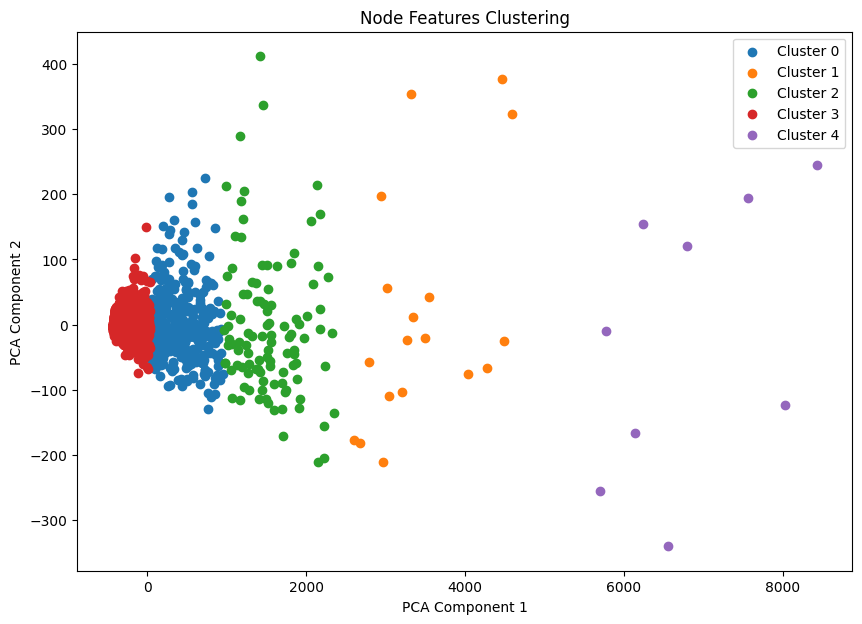

In [58]:
# Optionally, reduce dimensions for visualization using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot the clusters
plt.figure(figsize=(10, 7))
for i in range(n_clusters):
    cluster_points = reduced_features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.title('Node Features Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [93]:
# Stratified splitting to ensure all classes are represented in each split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in stratified_split.split(features, labels):
    X_train, X_rem = features[train_index], features[test_index]
    y_train, y_rem = labels[train_index], labels[test_index]
    train_node_ids, rem_node_ids = np.array(nodes)[train_index], np.array(nodes)[test_index]

# Split the remaining data into 50% validation and 50% test (which is 15% each of the total data)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in stratified_split.split(X_rem, y_rem):
    X_val, X_test = X_rem[val_index], X_rem[test_index]
    y_val, y_test = y_rem[val_index], y_rem[test_index]
    val_node_ids, test_node_ids = rem_node_ids[val_index], rem_node_ids[test_index]

In [80]:
# Reshape the data to match the input shape expected by the models
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [94]:
# Check the classes in each set
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_val:", np.unique(y_val))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0 1 2 3 4]
Unique classes in y_val: [0 1 2 3 4]
Unique classes in y_test: [0 1 2 3 4]


In [82]:
def create_rnn_model(input_shape, activation_function, optimizer):
    model = Sequential([
        Input(shape=input_shape),
        RNN(SimpleRNNCell(128, activation=activation_function)),
        Dense(64, activation='relu'),
        Dense(n_clusters, activation='softmax')  # Adjust for multi-class classification
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [83]:
def create_lstm_model(input_shape, activation_function, optimizer):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation=activation_function),
        Dense(64, activation='relu'),
        Dense(n_clusters, activation='softmax')  # Adjust for multi-class classification
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [84]:
def create_transformer_model(input_shape, activation_function, optimizer):
    inputs = Input(shape=input_shape)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=128)(inputs, inputs)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    attention_output = tf.keras.layers.Activation(activation_function)(attention_output)
    pooled_output = GlobalAveragePooling1D()(attention_output)
    outputs = Dense(n_clusters, activation='softmax')(pooled_output)  # Adjust for multi-class classification

    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [85]:
def build_hgnn_model(input_shape, output_shape, activation):
    input_layer = Input(shape=input_shape)
    x = Dense(64)(input_layer)
    if activation == 'leaky_relu':
        x = LeakyReLU()(x)
    else:
        x = tf.keras.layers.Activation(activation)(x)
    x = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

In [86]:
# Training and evaluation function with validation data
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, batch_size=32):
    # Train the model with validation data
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    
    # Evaluate the model on the test data
    y_pred_prob = model.predict(X_test)
    
    # Handle NaN values in y_pred_prob
    y_pred_prob = np.nan_to_num(y_pred_prob)
    
    # Normalize probabilities to sum to 1.0
    y_pred_prob = y_pred_prob / y_pred_prob.sum(axis=1, keepdims=True)
    
    # Debugging: Print shapes and unique classes
    print("y_test shape:", y_test.shape)
    print("y_pred_prob shape:", y_pred_prob.shape)
    print("Unique classes in y_test:", np.unique(y_test))
    
    # Check for NaN values after normalization
    if np.isnan(y_pred_prob).any():
        print("Warning: NaN values found in y_pred_prob after normalization")
    
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    
    return history, accuracy, precision, recall, f1, auc, y_pred

In [87]:
def plot_all_combinations(histories, model_name):
    plt.figure(figsize=(14, 5))
    
    for history, label in histories:
        epochs = range(1, len(history.history['loss']) + 1)
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history.history['loss'], label=f'{label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{model_name} - Loss vs Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['accuracy'], label=f'{label}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'{model_name} - Accuracy vs Epochs')
        plt.legend()
        
    plt.show()

def plot_best_combinations(best_combinations):
    plt.figure(figsize=(14, 5))
    
    for model, best_combination in best_combinations.items():
        if isinstance(best_combination[0], str):
            print(f"Skipping invalid entry in best_combination: {best_combination}")
            continue

        history, accuracy, precision, recall, f1, auc, activation, optimizer, y_pred = best_combination
        epochs = range(1, len(history.history['loss']) + 1)
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history.history['loss'], label=f'{model} ({activation}-{optimizer})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs Epochs for Best Combinations')

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['accuracy'], label=f'{model} ({activation}-{optimizer})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy vs Epochs for Best Combinations')
    
    plt.show()

In [88]:
activation_functions_rnn = {
    'tanh': 'tanh',
    'relu': 'relu',
    'leaky_relu': tf.keras.layers.LeakyReLU(alpha=0.01)
}
optimizers_rnn = {
    'adam': Adam(),
    'rmsprop': RMSprop(),
    'sgd': SGD(),
    'nadam': Nadam()
}

activation_functions_lstm = ['tanh', 'sigmoid', 'relu']
optimizers_lstm = {
    'adam': Adam(),
    'rmsprop': RMSprop(),
    'sgd': SGD(),
    'adamw': tfa.optimizers.AdamW(weight_decay=1e-4)
}

activation_functions_transformer = {
    'relu': 'relu',
    'gelu': tf.keras.activations.gelu,
    'swish': tf.keras.activations.swish
}
optimizers_transformer = {
    'adam': Adam(),
    'adamw': tfa.optimizers.AdamW(weight_decay=1e-4),
    'nadam': Nadam(),
    'adagrad': Adagrad()
}
activations_function_hgnn = ['relu', 'leaky_relu', 'tanh']
optimizers_hgnn = {
    'adam': Adam,
    'sgd': SGD,
    'rmsprop': RMSprop,
}

In [89]:
def train_and_evaluate_models(models_combinations, X_train, y_train, X_val, y_val, X_test, y_test):
    best_models = {}
    results_dict = defaultdict(list)
    
    for model_name, model_func, activations, optimizers in models_combinations:
        histories = []
        best_model = None
        best_score = -1
        
        for activation_name, activation_func in activations.items():
            for optimizer_name, optimizer_func in optimizers.items():
                print(f"Training {model_name} with activation: {activation_name} and optimizer: {optimizer_name}")
                
                model = model_func(X_train.shape[1:], activation_func, optimizer_func)
                try:
                    # Pass the validation data along with the training and testing data
                    history, accuracy, precision, recall, f1, auc, y_pred = train_and_evaluate_model(
                        model, X_train, y_train, X_val, y_val, X_test, y_test
                    )
                except Exception as e:
                    print(f"Error with {model_name}, activation {activation_name}, optimizer {optimizer_name}: {e}")
                    continue
                
                histories.append((history, f'{activation_name}-{optimizer_name}'))
                
                results_dict[model_name].append({
                    'Model': model_name,
                    'Activation Function': activation_name,
                    'Optimizer': optimizer_name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1 Score': f1,
                    'AUC': auc,
                    'history': history  # Added history to the results dictionary
                })
                
                avg_metrics = np.mean([accuracy, precision, recall, f1, auc])
                if avg_metrics > best_score:
                    best_score = avg_metrics
                    best_model = (model, accuracy, precision, recall, f1, auc, activation_name, optimizer_name, y_pred)
        
        best_models[model_name] = best_model
        
        results_df = pd.DataFrame(results_dict[model_name])
        print(f"\nResults for {model_name}:\n", results_df)
        
        plot_all_combinations(histories, model_name)  # Plot all combinations for this model
    
    return best_models, results_dict

In [90]:
def calculate_avg_metrics(results):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    avg_metrics = {metric: np.mean([res[metric] for res in results]) for metric in metrics}
    return avg_metrics

def choose_best_combination(results):
    best_combination = max(results, key=lambda x: np.mean([x[metric] for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']]))
    return best_combination

In [45]:
def save_results_to_file(model_name, results):
    with open(f'results_{model_name}.json', 'w') as file:
        json.dump(results, file, indent=4)

In [91]:
models_combinations = [
    ('RNN', create_rnn_model, activation_functions_rnn, optimizers_rnn),
    ('LSTM', create_lstm_model, {k: k for k in activation_functions_lstm}, optimizers_lstm),
    ('Transformer', create_transformer_model, activation_functions_transformer, optimizers_transformer)
]

Training RNN with activation: tanh and optimizer: adam
Epoch 1/100
42/42 [==============================] - 1s 8ms/step - loss: 0.7595 - accuracy: 0.7494 - val_loss: 0.6079 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5263 - accuracy: 0.8066 - val_loss: 0.4872 - val_accuracy: 0.8281
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4552 - accuracy: 0.8352 - val_loss: 0.4087 - val_accuracy: 0.8667
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4161 - accuracy: 0.8495 - val_loss: 0.4375 - val_accuracy: 0.8316
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4553 - accuracy: 0.8269 - val_loss: 0.4649 - val_accuracy: 0.8175
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4458 - accuracy: 0.8299 - val_loss: 0.4421 - val_accuracy: 0.8386
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4406 - accuracy: 0.8292 

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 9ms/step - loss: 0.6768 - accuracy: 0.7494 - val_loss: 0.5733 - val_accuracy: 0.7895
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5520 - accuracy: 0.7976 - val_loss: 0.6933 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5222 - accuracy: 0.7946 - val_loss: 0.5038 - val_accuracy: 0.7930
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5191 - accuracy: 0.8006 - val_loss: 0.4580 - val_accuracy: 0.8281
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4827 - accuracy: 0.8172 - val_loss: 0.4479 - val_accuracy: 0.8281
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.8209 - val_loss: 0.4901 - val_accuracy: 0.7579
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4712 - accuracy: 0.8164 - val_loss: 0.6780 - val_accuracy: 0.7333
Epoch 8/100
42/42 [======

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 1s 10ms/step - loss: 0.8768 - accuracy: 0.6817 - val_loss: 0.8137 - val_accuracy: 0.7053
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8087 - accuracy: 0.7081 - val_loss: 0.8453 - val_accuracy: 0.7053
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8230 - accuracy: 0.7096 - val_loss: 0.8158 - val_accuracy: 0.7053
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8030 - accuracy: 0.7178 - val_loss: 0.8052 - val_accuracy: 0.7123
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7791 - accuracy: 0.7201 - val_loss: 0.7437 - val_accuracy: 0.7158
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7875 - accuracy: 0.7231 - val_loss: 0.8162 - val_accuracy: 0.7158
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7927 - accuracy: 0.7246 - val_loss: 0.7897 - val_accuracy: 0.7193
Epoch 8/100


C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 21ms/step - loss: 0.7315 - accuracy: 0.7524 - val_loss: 0.5701 - val_accuracy: 0.8281
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5264 - accuracy: 0.7998 - val_loss: 0.7065 - val_accuracy: 0.7368
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.7810 - val_loss: 0.6097 - val_accuracy: 0.7368
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4953 - accuracy: 0.8044 - val_loss: 0.4272 - val_accuracy: 0.8351
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4529 - accuracy: 0.8157 - val_loss: 0.4377 - val_accuracy: 0.8175
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4040 - accuracy: 0.8473 - val_loss: 0.4416 - val_accuracy: 0.8491
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4332 - accuracy: 0.8330 - val_loss: 0.4056 - val_accuracy: 0.8596
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 9ms/step - loss: 13.1850 - accuracy: 0.4846 - val_loss: 10.9347 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 4.9690 - accuracy: 0.7239 - val_loss: 1.6482 - val_accuracy: 0.7825
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 3.2538 - accuracy: 0.7502 - val_loss: 1.9264 - val_accuracy: 0.8281
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 2.1088 - accuracy: 0.7615 - val_loss: 1.2280 - val_accuracy: 0.7474
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 2.3024 - accuracy: 0.7825 - val_loss: 0.8557 - val_accuracy: 0.8596
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 1.1576 - accuracy: 0.8322 - val_loss: 2.2802 - val_accuracy: 0.9053
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 1.5391 - accuracy: 0.8315 - val_loss: 3.2272 - val_accuracy: 0.8702
Epoch 8/100
42/42 [====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 10ms/step - loss: 9.1660 - accuracy: 0.4771 - val_loss: 8.8978 - val_accuracy: 0.3579
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 5.3049 - accuracy: 0.5959 - val_loss: 3.7527 - val_accuracy: 0.7614
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 4.7299 - accuracy: 0.6275 - val_loss: 3.6184 - val_accuracy: 0.7298
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 3.8900 - accuracy: 0.6667 - val_loss: 4.4216 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 3.7171 - accuracy: 0.6877 - val_loss: 4.2210 - val_accuracy: 0.7158
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 3.1539 - accuracy: 0.7329 - val_loss: 2.1531 - val_accuracy: 0.8561
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 3.4660 - accuracy: 0.7449 - val_loss: 2.7727 - val_accuracy: 0.6211
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 9ms/step - loss: 65.8236 - accuracy: 0.6298 - val_loss: 0.9781 - val_accuracy: 0.7158
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8886 - accuracy: 0.7269 - val_loss: 0.8462 - val_accuracy: 0.7298
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9271 - accuracy: 0.7276 - val_loss: 0.8151 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 1.0241 - accuracy: 0.7291 - val_loss: 0.8205 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8143 - accuracy: 0.7299 - val_loss: 0.8630 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8085 - accuracy: 0.7321 - val_loss: 0.8002 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8033 - accuracy: 0.7329 - val_loss: 1.0974 - val_accuracy: 0.7333
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 10ms/step - loss: 13.1563 - accuracy: 0.5214 - val_loss: 2.1708 - val_accuracy: 0.5474
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8906 - accuracy: 0.7246 - val_loss: 1.7202 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8690 - accuracy: 0.7449 - val_loss: 0.6633 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.7366 - val_loss: 0.7300 - val_accuracy: 0.7368
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.8172 - val_loss: 0.5852 - val_accuracy: 0.7368
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5804 - accuracy: 0.7449 - val_loss: 0.5701 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5143 - accuracy: 0.7397 - val_loss: 0.7297 - val_accuracy: 0.8281
Epoch 8/100
42/42 [====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 9ms/step - loss: 13.0030 - accuracy: 0.4628 - val_loss: 3.9970 - val_accuracy: 0.6842
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 4.7738 - accuracy: 0.6870 - val_loss: 3.5336 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 1.6317 - accuracy: 0.7622 - val_loss: 1.6014 - val_accuracy: 0.6912
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 1.0017 - accuracy: 0.8036 - val_loss: 0.8925 - val_accuracy: 0.8737
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7221 - accuracy: 0.8277 - val_loss: 1.1570 - val_accuracy: 0.8105
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9833 - accuracy: 0.8157 - val_loss: 0.8710 - val_accuracy: 0.7228
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8848 - accuracy: 0.7961 - val_loss: 1.4096 - val_accuracy: 0.9053
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 9ms/step - loss: 14.0008 - accuracy: 0.4507 - val_loss: 4.1589 - val_accuracy: 0.4912
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 7.6887 - accuracy: 0.5786 - val_loss: 12.1120 - val_accuracy: 0.3895
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 6.1456 - accuracy: 0.6388 - val_loss: 5.2195 - val_accuracy: 0.6561
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 5.6388 - accuracy: 0.6757 - val_loss: 7.1477 - val_accuracy: 0.6246
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 5.1080 - accuracy: 0.6622 - val_loss: 5.7547 - val_accuracy: 0.6035
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 4.3797 - accuracy: 0.7111 - val_loss: 3.3739 - val_accuracy: 0.6596
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 4.1439 - accuracy: 0.7306 - val_loss: 5.5199 - val_accuracy: 0.7439
Epoch 8/100
42/42 [====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.3010 - val_loss: nan - val_accuracy: 0.1930
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 8/100
42/42 [==============================] - 0s 2ms/step - 

C:\Users\marwa\AppData\Local\Temp\ipykernel_16156\145570283.py:13: RuntimeWarning: invalid value encountered in divide
  y_pred_prob = y_pred_prob / y_pred_prob.sum(axis=1, keepdims=True)
C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 10ms/step - loss: 12.4173 - accuracy: 0.5147 - val_loss: 2.2148 - val_accuracy: 0.6316
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 1.7014 - accuracy: 0.7359 - val_loss: 1.1735 - val_accuracy: 0.7088
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 1.0102 - accuracy: 0.7773 - val_loss: 0.8052 - val_accuracy: 0.8982
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.8397 - val_loss: 0.5749 - val_accuracy: 0.8842
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.8427 - val_loss: 0.7588 - val_accuracy: 0.8737
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5473 - accuracy: 0.8578 - val_loss: 0.4794 - val_accuracy: 0.9158
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.4072 - accuracy: 0.9074 - val_loss: 0.4943 - val_accuracy: 0.9333
Epoch 8/100
42/42 [====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


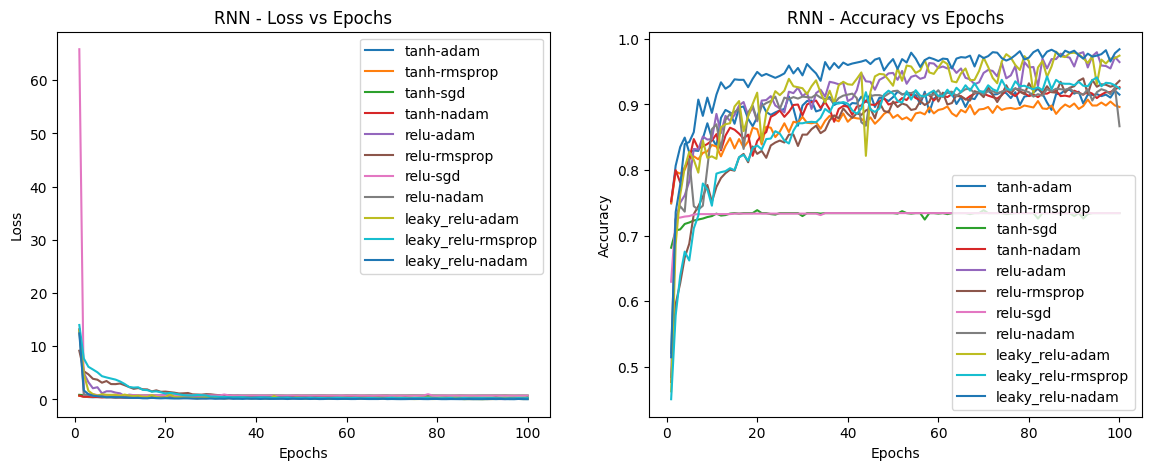

Training LSTM with activation: tanh and optimizer: adam
Epoch 1/100
42/42 [==============================] - 4s 17ms/step - loss: 0.8660 - accuracy: 0.6900 - val_loss: 0.4993 - val_accuracy: 0.8877
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.4149 - accuracy: 0.8721 - val_loss: 0.3968 - val_accuracy: 0.8807
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3227 - accuracy: 0.8939 - val_loss: 0.3026 - val_accuracy: 0.8912
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3121 - accuracy: 0.8886 - val_loss: 0.2952 - val_accuracy: 0.8947
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.2793 - accuracy: 0.9059 - val_loss: 0.3247 - val_accuracy: 0.8807
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.2685 - accuracy: 0.9029 - val_loss: 0.2631 - val_accuracy: 0.9053
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.2492 - accuracy: 0.906

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 3s 17ms/step - loss: 0.6095 - accuracy: 0.7938 - val_loss: 0.5131 - val_accuracy: 0.8140
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.4039 - accuracy: 0.8698 - val_loss: 0.3758 - val_accuracy: 0.8632
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3592 - accuracy: 0.8638 - val_loss: 0.3493 - val_accuracy: 0.8737
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3330 - accuracy: 0.8736 - val_loss: 0.2784 - val_accuracy: 0.9053
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3250 - accuracy: 0.8751 - val_loss: 0.4016 - val_accuracy: 0.8105
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3252 - accuracy: 0.8751 - val_loss: 0.3408 - val_accuracy: 0.8456
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3092 - accuracy: 0.8758 - val_loss: 0.2966 - val_accuracy: 0.8877
Epoch 8/100


C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 3s 17ms/step - loss: 0.9960 - accuracy: 0.7081 - val_loss: 0.8510 - val_accuracy: 0.7263
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7795 - accuracy: 0.7329 - val_loss: 0.7828 - val_accuracy: 0.7298
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7511 - accuracy: 0.7329 - val_loss: 0.7661 - val_accuracy: 0.7298
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7402 - accuracy: 0.7329 - val_loss: 0.8001 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.7494 - accuracy: 0.7329 - val_loss: 0.7565 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7582 - accuracy: 0.7329 - val_loss: 0.7473 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.7322 - accuracy: 0.7329 - val_loss: 0.7205 - val_accuracy: 0.7333
Epoch 8/100


C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 3s 17ms/step - loss: 0.6841 - accuracy: 0.7705 - val_loss: 0.4534 - val_accuracy: 0.8737
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.4000 - accuracy: 0.8789 - val_loss: 0.3598 - val_accuracy: 0.9018
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3219 - accuracy: 0.8849 - val_loss: 0.3174 - val_accuracy: 0.9018
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.2962 - accuracy: 0.8924 - val_loss: 0.2800 - val_accuracy: 0.9123
Epoch 5/100
42/42 [==============================] - 0s 7ms/step - loss: 0.2882 - accuracy: 0.8969 - val_loss: 0.3504 - val_accuracy: 0.8702
Epoch 6/100
42/42 [==============================] - 1s 12ms/step - loss: 0.2950 - accuracy: 0.8962 - val_loss: 0.2990 - val_accuracy: 0.8737
Epoch 7/100
42/42 [==============================] - 0s 8ms/step - loss: 0.2547 - accuracy: 0.8992 - val_loss: 0.2507 - val_accuracy: 0.9158
Epoch 8/100

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 12ms/step - loss: 0.6438 - accuracy: 0.7607 - val_loss: 0.5041 - val_accuracy: 0.7825
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5273 - accuracy: 0.7871 - val_loss: 0.5735 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.4552 - accuracy: 0.8405 - val_loss: 0.3926 - val_accuracy: 0.8807
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3605 - accuracy: 0.8698 - val_loss: 0.3783 - val_accuracy: 0.8246
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3292 - accuracy: 0.8796 - val_loss: 0.3470 - val_accuracy: 0.8737
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3874 - accuracy: 0.8570 - val_loss: 0.4276 - val_accuracy: 0.7965
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3367 - accuracy: 0.8713 - val_loss: 0.3475 - val_accuracy: 0.8772
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 2s 12ms/step - loss: 0.6378 - accuracy: 0.7728 - val_loss: 0.4640 - val_accuracy: 0.8667
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.4222 - accuracy: 0.8608 - val_loss: 0.3889 - val_accuracy: 0.8842
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3871 - accuracy: 0.8593 - val_loss: 0.3823 - val_accuracy: 0.8842
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3634 - accuracy: 0.8646 - val_loss: 0.3687 - val_accuracy: 0.8737
Epoch 5/100
42/42 [==============================] - 0s 9ms/step - loss: 0.3381 - accuracy: 0.8646 - val_loss: 0.3868 - val_accuracy: 0.8421
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3442 - accuracy: 0.8668 - val_loss: 0.3995 - val_accuracy: 0.8175
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 0.2997 - accuracy: 0.8826 - val_loss: 0.3974 - val_accuracy: 0.8246
Epoch 8/100


C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 3s 12ms/step - loss: 0.9474 - accuracy: 0.7005 - val_loss: 0.7916 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 0.7460 - accuracy: 0.7344 - val_loss: 0.7175 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.7344 - val_loss: 0.6928 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6619 - accuracy: 0.7344 - val_loss: 0.6510 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 7ms/step - loss: 0.6581 - accuracy: 0.7344 - val_loss: 0.6410 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.7344 - val_loss: 0.6693 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.7344 - val_loss: 0.6213 - val_accuracy: 0.7333
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 2s 12ms/step - loss: 0.7277 - accuracy: 0.7239 - val_loss: 0.7170 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5255 - accuracy: 0.7946 - val_loss: 0.4485 - val_accuracy: 0.8491
Epoch 3/100
42/42 [==============================] - 0s 9ms/step - loss: 0.5127 - accuracy: 0.7871 - val_loss: 0.5472 - val_accuracy: 0.7614
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.4462 - accuracy: 0.8187 - val_loss: 0.3872 - val_accuracy: 0.8702
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3855 - accuracy: 0.8600 - val_loss: 0.3713 - val_accuracy: 0.8912
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3851 - accuracy: 0.8555 - val_loss: 0.3728 - val_accuracy: 0.8596
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.3348 - accuracy: 0.8781 - val_loss: 0.4394 - val_accuracy: 0.7754
Epoch 8/100


C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 11ms/step - loss: 6.4249 - accuracy: 0.6840 - val_loss: 5.6183 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 1.8694 - accuracy: 0.7043 - val_loss: 0.8060 - val_accuracy: 0.7509
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.9892 - accuracy: 0.7810 - val_loss: 0.6927 - val_accuracy: 0.7895
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.8126 - val_loss: 0.5044 - val_accuracy: 0.8842
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.8706 - val_loss: 0.4479 - val_accuracy: 0.8772
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 0.3971 - accuracy: 0.8894 - val_loss: 0.5484 - val_accuracy: 0.9018
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.4120 - accuracy: 0.8962 - val_loss: 0.3493 - val_accuracy: 0.9053
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 12ms/step - loss: 3.1219 - accuracy: 0.7577 - val_loss: 2.4272 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 1.8995 - accuracy: 0.8269 - val_loss: 2.6088 - val_accuracy: 0.6947
Epoch 3/100
42/42 [==============================] - 0s 6ms/step - loss: 2.9101 - accuracy: 0.8104 - val_loss: 2.2610 - val_accuracy: 0.9053
Epoch 4/100
42/42 [==============================] - 0s 7ms/step - loss: 2.3638 - accuracy: 0.8390 - val_loss: 1.8005 - val_accuracy: 0.8596
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 3.0823 - accuracy: 0.8149 - val_loss: 0.8623 - val_accuracy: 0.9088
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 1.7203 - accuracy: 0.8518 - val_loss: 1.1319 - val_accuracy: 0.8912
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 3.2360 - accuracy: 0.8194 - val_loss: 1.0332 - val_accuracy: 0.8211
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 2s 12ms/step - loss: 13.7642 - accuracy: 0.4868 - val_loss: 1.3707 - val_accuracy: 0.7158
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 1.2598 - accuracy: 0.7193 - val_loss: 1.1221 - val_accuracy: 0.7193
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 1.1545 - accuracy: 0.7193 - val_loss: 1.0253 - val_accuracy: 0.7263
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.9800 - accuracy: 0.7314 - val_loss: 0.9524 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.9223 - accuracy: 0.7336 - val_loss: 0.9029 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 1.3284 - accuracy: 0.7111 - val_loss: 0.8637 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.9955 - accuracy: 0.7261 - val_loss: 0.8500 - val_accuracy: 0.7333
Epoch 8/100

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 11ms/step - loss: 8.6083 - accuracy: 0.6178 - val_loss: 35.3419 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 4.8904 - accuracy: 0.6238 - val_loss: 1.9194 - val_accuracy: 0.8702
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 1.8294 - accuracy: 0.7622 - val_loss: 1.3162 - val_accuracy: 0.8772
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.9992 - accuracy: 0.8299 - val_loss: 1.4119 - val_accuracy: 0.7263
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.7212 - accuracy: 0.8420 - val_loss: 0.8651 - val_accuracy: 0.8947
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.8683 - val_loss: 0.4571 - val_accuracy: 0.8912
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.7109 - accuracy: 0.8473 - val_loss: 0.5337 - val_accuracy: 0.8982
Epoch 8/100
42/42 [====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


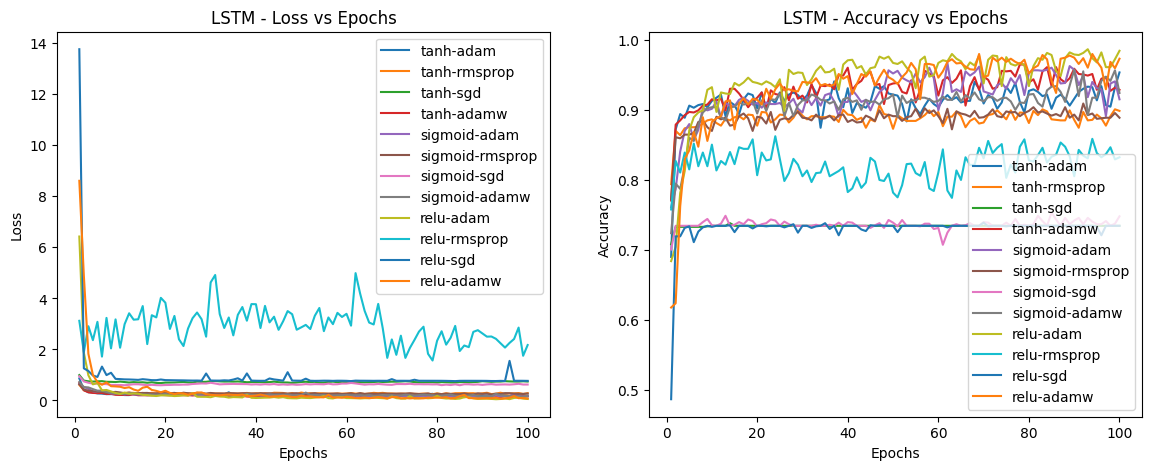

Training Transformer with activation: relu and optimizer: adam
Epoch 1/100
42/42 [==============================] - 1s 10ms/step - loss: 0.7838 - accuracy: 0.7178 - val_loss: 0.7185 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.7359 - val_loss: 0.6828 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6188 - accuracy: 0.7366 - val_loss: 0.5871 - val_accuracy: 0.7298
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.5600 - accuracy: 0.7675 - val_loss: 0.5079 - val_accuracy: 0.8386
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 0.5152 - accuracy: 0.7878 - val_loss: 0.5945 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 0.4367 - accuracy: 0.8307 - val_loss: 0.4023 - val_accuracy: 0.8491
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.4397 - accuracy

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 12ms/step - loss: 0.8419 - accuracy: 0.7201 - val_loss: 0.7470 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 0.7288 - accuracy: 0.7344 - val_loss: 0.7335 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.7351 - val_loss: 0.6485 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.6669 - accuracy: 0.7389 - val_loss: 0.6252 - val_accuracy: 0.7930
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 0.5793 - accuracy: 0.7615 - val_loss: 0.5620 - val_accuracy: 0.7368
Epoch 6/100
42/42 [==============================] - 0s 7ms/step - loss: 0.5386 - accuracy: 0.7878 - val_loss: 0.5201 - val_accuracy: 0.7754
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.4732 - accuracy: 0.8059 - val_loss: 0.6494 - val_accuracy: 0.7368
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 2s 13ms/step - loss: 0.8080 - accuracy: 0.7141 - val_loss: 0.7378 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 9ms/step - loss: 0.6732 - accuracy: 0.7389 - val_loss: 0.6900 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6393 - accuracy: 0.7397 - val_loss: 0.5862 - val_accuracy: 0.8316
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6140 - accuracy: 0.7449 - val_loss: 0.5401 - val_accuracy: 0.7439
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.5360 - accuracy: 0.7773 - val_loss: 0.5822 - val_accuracy: 0.7509
Epoch 6/100
42/42 [==============================] - 0s 7ms/step - loss: 0.5725 - accuracy: 0.7562 - val_loss: 0.6777 - val_accuracy: 0.7018
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 0.5144 - accuracy: 0.7788 - val_loss: 0.4928 - val_accuracy: 0.8070
Epoch 8/100


C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 12ms/step - loss: 0.8211 - accuracy: 0.7028 - val_loss: 0.7737 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7296 - accuracy: 0.7344 - val_loss: 0.7389 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7064 - accuracy: 0.7374 - val_loss: 0.7203 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.7359 - val_loss: 0.6830 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 7ms/step - loss: 0.6830 - accuracy: 0.7321 - val_loss: 0.6918 - val_accuracy: 0.7474
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6586 - accuracy: 0.7366 - val_loss: 0.6817 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6531 - accuracy: 0.7366 - val_loss: 0.6304 - val_accuracy: 0.7298
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 2s 12ms/step - loss: 0.8188 - accuracy: 0.7178 - val_loss: 0.8162 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7573 - accuracy: 0.7344 - val_loss: 0.7490 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7250 - accuracy: 0.7344 - val_loss: 0.6959 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.7336 - val_loss: 0.7246 - val_accuracy: 0.7298
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6299 - accuracy: 0.7419 - val_loss: 0.5801 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 8ms/step - loss: 0.5224 - accuracy: 0.7893 - val_loss: 0.4317 - val_accuracy: 0.8246
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 0.4963 - accuracy: 0.7983 - val_loss: 0.4317 - val_accuracy: 0.8667
Epoch 8/100


C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 2s 12ms/step - loss: 0.8336 - accuracy: 0.7216 - val_loss: 0.7663 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7488 - accuracy: 0.7344 - val_loss: 0.7548 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7374 - accuracy: 0.7344 - val_loss: 0.7150 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 12ms/step - loss: 0.6854 - accuracy: 0.7321 - val_loss: 0.6342 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6368 - accuracy: 0.7502 - val_loss: 0.5822 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 7ms/step - loss: 0.5981 - accuracy: 0.7457 - val_loss: 0.5211 - val_accuracy: 0.7544
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 0.5482 - accuracy: 0.7682 - val_loss: 0.5380 - val_accuracy: 0.7930
Epoch 8/100

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 2s 14ms/step - loss: 0.8424 - accuracy: 0.7103 - val_loss: 0.7751 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 9ms/step - loss: 0.7621 - accuracy: 0.7344 - val_loss: 0.7789 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.7558 - accuracy: 0.7344 - val_loss: 0.7525 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 0.7368 - accuracy: 0.7344 - val_loss: 0.7259 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.7065 - accuracy: 0.7344 - val_loss: 0.6975 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6607 - accuracy: 0.7351 - val_loss: 0.6025 - val_accuracy: 0.7439
Epoch 7/100
42/42 [==============================] - 0s 10ms/step - loss: 0.6192 - accuracy: 0.7381 - val_loss: 0.5576 - val_accuracy: 0.7333
Epoch 8/100

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 12ms/step - loss: 0.8438 - accuracy: 0.7043 - val_loss: 0.7660 - val_accuracy: 0.7298
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 0.7563 - accuracy: 0.7321 - val_loss: 0.7436 - val_accuracy: 0.7298
Epoch 3/100
42/42 [==============================] - 0s 7ms/step - loss: 0.7262 - accuracy: 0.7329 - val_loss: 0.7254 - val_accuracy: 0.7298
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7178 - accuracy: 0.7329 - val_loss: 0.7060 - val_accuracy: 0.7298
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.7306 - val_loss: 0.7036 - val_accuracy: 0.7298
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.7344 - val_loss: 0.9838 - val_accuracy: 0.4947
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6815 - accuracy: 0.7254 - val_loss: 0.6613 - val_accuracy: 0.7228
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 13ms/step - loss: 0.8428 - accuracy: 0.7043 - val_loss: 0.7682 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7687 - accuracy: 0.7344 - val_loss: 0.7706 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7415 - accuracy: 0.7344 - val_loss: 0.7401 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 0.7270 - accuracy: 0.7344 - val_loss: 0.7139 - val_accuracy: 0.7298
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.7344 - val_loss: 0.6940 - val_accuracy: 0.7298
Epoch 6/100
42/42 [==============================] - 0s 7ms/step - loss: 0.6278 - accuracy: 0.7427 - val_loss: 0.7249 - val_accuracy: 0.6737
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6697 - accuracy: 0.7306 - val_loss: 0.6128 - val_accuracy: 0.7333
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 2s 12ms/step - loss: 0.8678 - accuracy: 0.7171 - val_loss: 0.7767 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7676 - accuracy: 0.7344 - val_loss: 0.7765 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 7ms/step - loss: 0.7567 - accuracy: 0.7344 - val_loss: 0.7584 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7420 - accuracy: 0.7344 - val_loss: 0.7521 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 0.7327 - accuracy: 0.7344 - val_loss: 0.7145 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.7344 - val_loss: 0.6484 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 0.6285 - accuracy: 0.7464 - val_loss: 0.5718 - val_accuracy: 0.7333
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
42/42 [==============================] - 4s 21ms/step - loss: 0.8245 - accuracy: 0.7171 - val_loss: 0.7762 - val_accuracy: 0.7333
Epoch 2/100
42/42 [==============================] - 1s 12ms/step - loss: 0.7547 - accuracy: 0.7344 - val_loss: 0.7610 - val_accuracy: 0.7333
Epoch 3/100
42/42 [==============================] - 0s 11ms/step - loss: 0.7371 - accuracy: 0.7344 - val_loss: 0.7271 - val_accuracy: 0.7333
Epoch 4/100
42/42 [==============================] - 0s 9ms/step - loss: 0.7000 - accuracy: 0.7344 - val_loss: 0.6609 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 9ms/step - loss: 0.6310 - accuracy: 0.7359 - val_loss: 0.6686 - val_accuracy: 0.7088
Epoch 6/100
42/42 [==============================] - 1s 14ms/step - loss: 0.5779 - accuracy: 0.7570 - val_loss: 0.5382 - val_accuracy: 0.8351
Epoch 7/100
42/42 [==============================] - 1s 13ms/step - loss: 0.5260 - accuracy: 0.7840 - val_loss: 0.8637 - val_accuracy: 0.6632
Epoch 8/

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


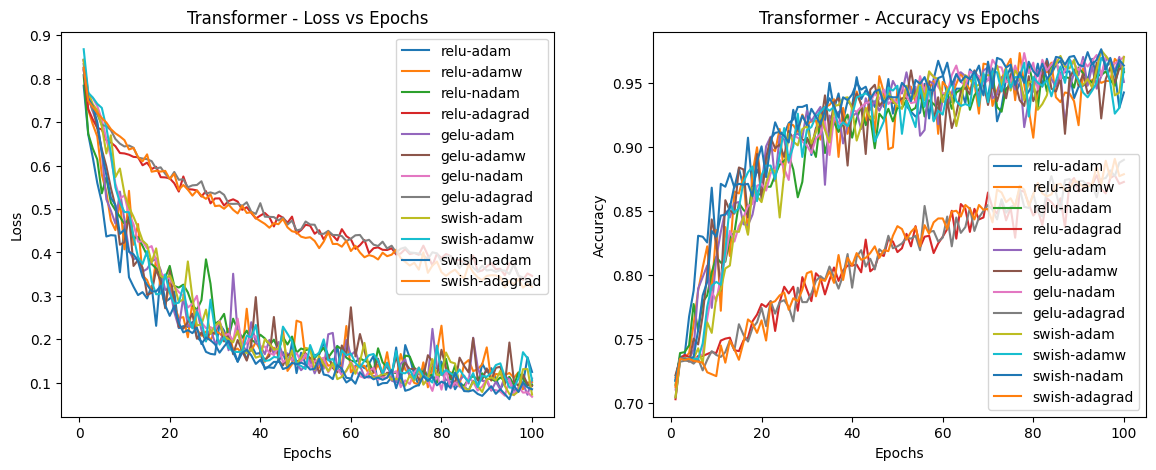

In [92]:
best_models, results_dict = train_and_evaluate_models(
    models_combinations, X_train, y_train, X_val, y_val, X_test, y_test
)

In [95]:
# First train and evaluate the HGNN model
results_hgnn = []
histories_hgnn = []
best_hgnn_model = None
best_hgnn_score = -1

for activation in activations_function_hgnn:
    for optimizer_name, optimizer in optimizers_hgnn.items():
        print(f"Training HGNN with activation: {activation} and optimizer: {optimizer_name}")
        
        hgnn_model = build_hgnn_model((X_train.shape[1],), n_clusters, activation)
        hgnn_model.compile(optimizer=optimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        try:
            # Pass the validation data along with the training and testing data
            history, accuracy, precision, recall, f1, auc, y_pred = train_and_evaluate_model(
                hgnn_model, X_train, y_train, X_val, y_val, X_test, y_test
            )
        except Exception as e:
            print(f"Error with HGNN, activation {activation}, optimizer {optimizer_name}: {e}")
            continue
        
        histories_hgnn.append((history, f'{activation}-{optimizer_name}'))
        
        results_hgnn.append({
            'Model': 'HGNN',
            'Activation Function': activation,
            'Optimizer': optimizer_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'history': history  # Added history to the results dictionary
        })
        
        avg_metrics = np.mean([accuracy, precision, recall, f1, auc])
        if avg_metrics > best_hgnn_score:
            best_hgnn_score = avg_metrics
            best_hgnn_model = (hgnn_model, accuracy, precision, recall, f1, auc, activation, optimizer_name, y_pred)

Training HGNN with activation: relu and optimizer: adam
Epoch 1/100
42/42 [==============================] - 1s 5ms/step - loss: 17.4935 - accuracy: 0.4123 - val_loss: 12.6088 - val_accuracy: 0.6035
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 6.9664 - accuracy: 0.6524 - val_loss: 3.6640 - val_accuracy: 0.6912
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 2.4309 - accuracy: 0.7111 - val_loss: 2.7758 - val_accuracy: 0.7404
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 1.9598 - accuracy: 0.7494 - val_loss: 4.0298 - val_accuracy: 0.7228
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 2.2128 - accuracy: 0.7600 - val_loss: 3.3836 - val_accuracy: 0.6772
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 1.9789 - accuracy: 0.7803 - val_loss: 1.3474 - val_accuracy: 0.8000
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 1.1034 - accuracy: 0.78

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 6ms/step - loss: 35.2578 - accuracy: 0.6020 - val_loss: 1.4337 - val_accuracy: 0.6702
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 1.4417 - accuracy: 0.7035 - val_loss: 1.3250 - val_accuracy: 0.7263
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 1.2682 - accuracy: 0.7336 - val_loss: 1.2300 - val_accuracy: 0.7298
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 1.1862 - accuracy: 0.7344 - val_loss: 1.1486 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 1.1316 - accuracy: 0.7344 - val_loss: 1.0995 - val_accuracy: 0.7333
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 1.0660 - accuracy: 0.7344 - val_loss: 1.0530 - val_accuracy: 0.7333
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 1.0250 - accuracy: 0.7344 - val_loss: 1.0137 - val_accuracy: 0.7333
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 5ms/step - loss: 13.1624 - accuracy: 0.2807 - val_loss: 3.9538 - val_accuracy: 0.5825
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 2.9386 - accuracy: 0.6268 - val_loss: 2.4708 - val_accuracy: 0.8386
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 2.6517 - accuracy: 0.7223 - val_loss: 2.0949 - val_accuracy: 0.6982
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 2.6351 - accuracy: 0.7246 - val_loss: 2.8122 - val_accuracy: 0.7333
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 2.5393 - accuracy: 0.7449 - val_loss: 2.8555 - val_accuracy: 0.7158
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 2.1260 - accuracy: 0.7690 - val_loss: 2.1678 - val_accuracy: 0.7719
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 2.2535 - accuracy: 0.7562 - val_loss: 0.9754 - val_accuracy: 0.8211
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 6ms/step - loss: 16.4429 - accuracy: 0.3679 - val_loss: 6.6608 - val_accuracy: 0.5614
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 5.1879 - accuracy: 0.5162 - val_loss: 5.6861 - val_accuracy: 0.5965
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 4.5526 - accuracy: 0.6020 - val_loss: 5.0813 - val_accuracy: 0.6246
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 3.4782 - accuracy: 0.6764 - val_loss: 1.8631 - val_accuracy: 0.7053
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 2.3061 - accuracy: 0.7442 - val_loss: 2.6250 - val_accuracy: 0.8070
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 2.5983 - accuracy: 0.7630 - val_loss: 2.2587 - val_accuracy: 0.7088
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 2.1290 - accuracy: 0.7765 - val_loss: 1.4438 - val_accuracy: 0.8035
Epoch 8/100
42/42 [=====

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 6ms/step - loss: 84123955757056.0000 - accuracy: 0.2543 - val_loss: 1177292948635648.0000 - val_accuracy: 0.1930
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 2550041583722213299716096.0000 - accuracy: 0.2265 - val_loss: 5419615362446214238830592.0000 - val_accuracy: 0.1930
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 6183891162792554727555656979578880.0000 - accuracy: 0.2190 - val_loss: 33430706934306015715481088572784640.0000 - val_accuracy: 0.1930
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1813 - val_loss: nan - val_accuracy: 0.1930
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1956 - val_loss: nan - val_accuracy: 0.1930
Epoch 7/100
42/42 [======================

C:\Users\marwa\AppData\Local\Temp\ipykernel_16156\145570283.py:13: RuntimeWarning: invalid value encountered in divide
  y_pred_prob = y_pred_prob / y_pred_prob.sum(axis=1, keepdims=True)
C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 5ms/step - loss: 9.3799 - accuracy: 0.5320 - val_loss: 6.6280 - val_accuracy: 0.4632
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 5.0051 - accuracy: 0.6208 - val_loss: 6.2358 - val_accuracy: 0.4807
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 4.3992 - accuracy: 0.6704 - val_loss: 4.2331 - val_accuracy: 0.5649
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 4.1921 - accuracy: 0.6637 - val_loss: 7.4711 - val_accuracy: 0.6632
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 3.8563 - accuracy: 0.7314 - val_loss: 3.6275 - val_accuracy: 0.6947
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 4.0149 - accuracy: 0.7397 - val_loss: 2.2696 - val_accuracy: 0.7544
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 3.7514 - accuracy: 0.7314 - val_loss: 9.3870 - val_accuracy: 0.6140
Epoch 8/100
42/42 [======

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 7ms/step - loss: 0.9874 - accuracy: 0.6531 - val_loss: 0.8468 - val_accuracy: 0.7018
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 0.8132 - accuracy: 0.7043 - val_loss: 0.8988 - val_accuracy: 0.7053
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 0.8021 - accuracy: 0.7058 - val_loss: 0.7938 - val_accuracy: 0.7053
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7842 - accuracy: 0.7081 - val_loss: 0.7855 - val_accuracy: 0.7088
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7975 - accuracy: 0.7126 - val_loss: 0.7859 - val_accuracy: 0.7123
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7896 - accuracy: 0.7163 - val_loss: 0.7947 - val_accuracy: 0.7193
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.7856 - accuracy: 0.7201 - val_loss: 0.7957 - val_accuracy: 0.7193
Epoch 8/100
42/42 [======

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 1s 5ms/step - loss: 0.9027 - accuracy: 0.6576 - val_loss: 0.6742 - val_accuracy: 0.7158
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 0.6119 - accuracy: 0.7517 - val_loss: 0.5763 - val_accuracy: 0.8491
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 0.5703 - accuracy: 0.7810 - val_loss: 0.5775 - val_accuracy: 0.7404
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5238 - accuracy: 0.8111 - val_loss: 0.5309 - val_accuracy: 0.8246
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 0.4874 - accuracy: 0.8149 - val_loss: 0.4781 - val_accuracy: 0.8526
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 0.4647 - accuracy: 0.8345 - val_loss: 0.4731 - val_accuracy: 0.8000
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.8367 - val_loss: 0.4356 - val_accuracy: 0.8386
Epoch 8/100
42/42 [======

C:\Users\marwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
results_hgnn_df = pd.DataFrame(results_hgnn)
print(f"\nResults for HGNN:\n", results_hgnn_df)


Results for HGNN:
   Model Activation Function Optimizer  Accuracy  Precision    Recall  \
0  HGNN                relu      adam  0.940351   0.933775  0.940351   
1  HGNN                relu       sgd  0.736842   0.542936  0.736842   
2  HGNN                relu   rmsprop  0.905263   0.883305  0.905263   
3  HGNN          leaky_relu      adam  0.922807   0.932253  0.922807   
4  HGNN          leaky_relu   rmsprop  0.912281   0.926281  0.912281   
5  HGNN                tanh      adam  0.908772   0.865755  0.908772   
6  HGNN                tanh       sgd  0.736842   0.542936  0.736842   
7  HGNN                tanh   rmsprop  0.905263   0.856738  0.905263   

   F1 Score       AUC                                            history  
0  0.935349  0.594582  <keras.src.callbacks.History object at 0x00000...  
1  0.625199  0.531834  <keras.src.callbacks.History object at 0x00000...  
2  0.889698  0.764682  <keras.src.callbacks.History object at 0x00000...  
3  0.919660  0.762703  <keras.s

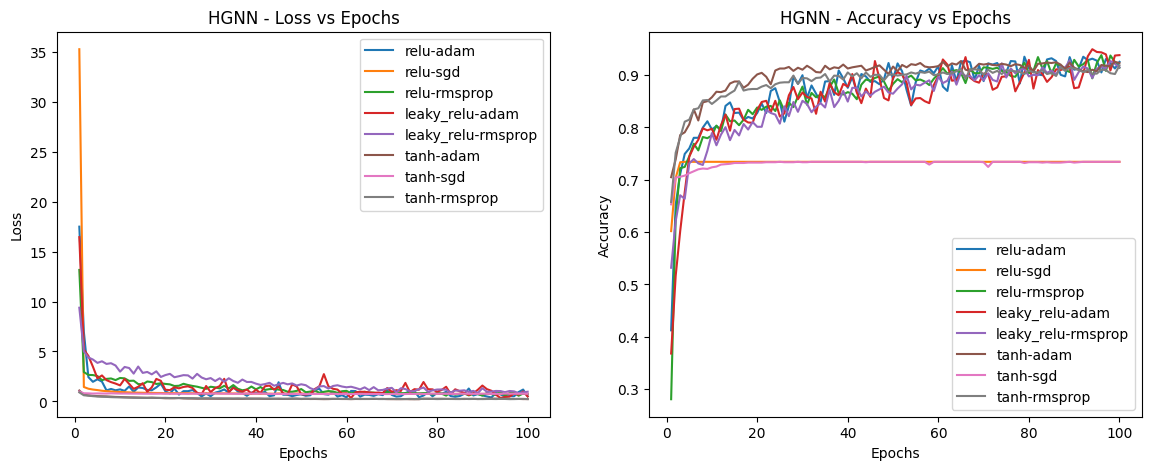

In [97]:
# Plot learning and loss curves for HGNN
plot_all_combinations(histories_hgnn, 'HGNN')  # Plot all combinations for HGNN


In [98]:
# Add HGNN results to the results_dict for comparison
results_dict['HGNN'] = results_hgnn

In [99]:
best_combinations = {model: choose_best_combination(results) for model, results in results_dict.items()}
print(f"Best combinations: {best_combinations}")

Best combinations: {'RNN': {'Model': 'RNN', 'Activation Function': 'relu', 'Optimizer': 'adam', 'Accuracy': 0.9473684210526315, 'Precision': 0.9581570749303164, 'Recall': 0.9473684210526315, 'F1 Score': 0.94736374001518, 'AUC': 0.9495972797028452, 'history': <keras.src.callbacks.History object at 0x00000164DD9F2510>}, 'LSTM': {'Model': 'LSTM', 'Activation Function': 'relu', 'Optimizer': 'adamw', 'Accuracy': 0.9719298245614035, 'Precision': 0.9674128169973045, 'Recall': 0.9719298245614035, 'F1 Score': 0.9691913109086537, 'AUC': 0.9976455591377704, 'history': <keras.src.callbacks.History object at 0x00000164FE375950>}, 'Transformer': {'Model': 'Transformer', 'Activation Function': 'gelu', 'Optimizer': 'adamw', 'Accuracy': 0.968421052631579, 'Precision': 0.9669983926678294, 'Recall': 0.968421052631579, 'F1 Score': 0.9672909546593756, 'AUC': 0.9933160857615533, 'history': <keras.src.callbacks.History object at 0x0000016507F10090>}, 'HGNN': {'Model': 'HGNN', 'Activation Function': 'tanh', '

In [100]:
# Ensure that best_combinations contains only numeric values for the metrics
best_combinations_numeric = {
    model: {k: v for k, v in combination.items() if isinstance(v, (int, float))}
    for model, combination in best_combinations.items()
}

In [101]:
best_overall_model = max(
    best_combinations.items(),
    key=lambda x: np.mean([x[1]['Accuracy'], x[1]['Precision'], x[1]['Recall'], x[1]['F1 Score'], x[1]['AUC']])
)

In [102]:
if best_overall_model:
    model_name, model_info = best_overall_model
    print(f"\nBest overall model: {model_name}")
    print(f"Activation Function: {model_info['Activation Function']}")
    print(f"Optimizer: {model_info['Optimizer']}")
    print(f"Accuracy: {model_info['Accuracy']}")
    print(f"Precision: {model_info['Precision']}")
    print(f"Recall: {model_info['Recall']}")
    print(f"F1 Score: {model_info['F1 Score']}")
    print(f"AUC: {model_info['AUC']}")
    predictions_df = pd.DataFrame({
        'Node': test_node_ids,
        'Predicted Label': y_pred,  # y_pred
        'True Label': y_test
    })
    print(f"\nPrediction results for best model:\n", predictions_df)


Best overall model: LSTM
Activation Function: relu
Optimizer: adamw
Accuracy: 0.9719298245614035
Precision: 0.9674128169973045
Recall: 0.9719298245614035
F1 Score: 0.9691913109086537
AUC: 0.9976455591377704

Prediction results for best model:
      Node  Predicted Label  True Label
0     329                3           3
1     106                3           3
2    1140                3           3
3    1001                3           3
4     731                3           3
..    ...              ...         ...
280  1836                0           0
281  1532                3           3
282   979                3           3
283  1488                3           0
284  1516                3           3

[285 rows x 3 columns]
